
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Extended Data Figure 9
-----

In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import squareform, pdist

import matplotlib.pylab as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

import seaborn as sns

import os
import sys
import random

A_col = "#3288BD"
B_col = "#D53E4F"

import warnings
warnings.filterwarnings('ignore')

random.seed(42)

-----
##### Set up input / output directories

In [5]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir2 = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir2, 'figures')
root_dir = '/Users/mehdi/Documents/Nature_Submission'
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [6]:
sys.path.append(str(root_dir2))
import scripts.ml_utils as mu

-----
##### Load & prepare data 

In [7]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.txt'), sep='\t', index_col=0)

kzm611_nhm = kzm611_md[kzm611_md.Burden=='low'].copy()
nhm_samples = kzm611_nhm.index.tolist()

naive_samples = kzm611_md[kzm611_md.Therapy=='Pre-Therapy'].index.tolist()
treated_samples = kzm611_md[kzm611_md.Therapy=='Post-Therapy'].index.tolist()

naive_nhm_samples = [x for x in naive_samples if x in nhm_samples]
treated_nhm_samples = [x for x in treated_samples if x in nhm_samples]

In [8]:
## Load df for samples that passed both time & burden thresholds to show platinum signature
topr_quad = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_topRightQuad.tsv'), sep='\t', index_col=0)
topr_quad_samples = topr_quad.index.tolist()
print(f"Number of samples above time & burden thresholds: {len(topr_quad_samples)}")

## Divie samples into sig- & sig+ groups
sigN_sbs_samples = topr_quad[topr_quad.Platin_sbs=='N'].index.tolist()
sigP_sbs_samples = topr_quad[topr_quad.Platin_sbs=='Y'].index.tolist()
sigN_dbs_samples = topr_quad[topr_quad.Platin_dbs=='N'].index.tolist()
sigP_dbs_samples = topr_quad[topr_quad.Platin_dbs=='Y'].index.tolist()

Number of samples above time & burden thresholds: 111


In [9]:
## Load therapy data at class and individual drug levels
class_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_classes_NY.txt'), sep='\t', index_col=0)
drugs_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_individuals_counts.txt'), sep='\t', index_col=0)

drugs_df = drugs_df.apply(lambda x: ['Y' if y > 0 else 'N' for y in x])
drugs_df = drugs_df.drop([x for x in drugs_df.columns if 'Y' not in drugs_df[x].tolist()], axis=1)

In [10]:
pret_samples = kzm611_md[kzm611_md.Therapy=='Pre-Therapy'].index.tolist()

In [11]:
pret_random_topq = random.sample(pret_samples, k=len(topr_quad_samples))
pret_random_P = random.sample(pret_samples, k=len(sigP_sbs_samples))
pret_random_N = random.sample(pret_samples, k=len(sigN_sbs_samples))

In [52]:
fn48 = os.path.join(root_dir, 'source_data/KZM_mutation_catalogs/KZM.CN48.txt')
fn32 = os.path.join(root_dir, 'source_data/KZM_mutation_catalogs/KZM611_SV_matrix_rev2.tsv')

mat48_df, mat48_rel, mat48_nhm, mat48_nhm_rel = mu.get_context(fn48, nhm_samples)
mat32_df, mat32_rel, mat32_nhm, mat32_nhm_rel = mu.get_context(fn32, nhm_samples)


In [71]:
print(mat32_df.columns.tolist())

['clustered_del_1-10Kb', 'clustered_del_10-100Kb', 'clustered_del_100Kb-1Mb', 'clustered_del_1Mb-10Mb', 'clustered_del_>10Mb', 'clustered_tds_1-10Kb', 'clustered_tds_10-100Kb', 'clustered_tds_100Kb-1Mb', 'clustered_tds_1Mb-10Mb', 'clustered_tds_>10Mb', 'clustered_inv_1-10Kb', 'clustered_inv_10-100Kb', 'clustered_inv_100Kb-1Mb', 'clustered_inv_1Mb-10Mb', 'clustered_inv_>10Mb', 'clustered_trans', 'non-clustered_del_1-10Kb', 'non-clustered_del_10-100Kb', 'non-clustered_del_100Kb-1Mb', 'non-clustered_del_1Mb-10Mb', 'non-clustered_del_>10Mb', 'non-clustered_tds_1-10Kb', 'non-clustered_tds_10-100Kb', 'non-clustered_tds_100Kb-1Mb', 'non-clustered_tds_1Mb-10Mb', 'non-clustered_tds_>10Mb', 'non-clustered_inv_1-10Kb', 'non-clustered_inv_10-100Kb', 'non-clustered_inv_100Kb-1Mb', 'non-clustered_inv_1Mb-10Mb', 'non-clustered_inv_>10Mb', 'non-clustered_trans']


In [53]:
SV_samples = mat32_df.index.tolist()
CNV_samples = mat48_df.index.tolist()

pret_samples_sv = [x for x in pret_samples if x in SV_samples]
pret_samples_cnv = [x for x in pret_samples if x in CNV_samples]

sigN_sbs_samples_sv = [x for x in sigN_sbs_samples if x in SV_samples]
sigP_sbs_samples_sv = [x for x in sigP_sbs_samples if x in SV_samples]
sigN_sbs_samples_cnv = [x for x in sigN_sbs_samples if x in CNV_samples]
sigP_sbs_samples_cnv = [x for x in sigP_sbs_samples if x in CNV_samples]


len(sigN_sbs_samples_sv), len(sigP_sbs_samples_sv), len(sigN_sbs_samples_cnv), len(sigP_sbs_samples_cnv)

(45, 63, 45, 65)

In [54]:
feats_sv = mu.get_SHAP_features(mat32_df, class_df, pret_samples, 'SV', 1000)
feats_sv = feats_sv.rename(index={'clustered_trans': 'clustered_Translocations', 'non-clustered_trans': 'non-clustered_Translocations'})

Alkylating agent, Other: 25
Anthracyclines: 226
Antimetabolite: 95
Antitumor antibiotic: 3
Camptothecin analogs: 112
Chromomycins: 57
Hydrazines and Triazines: 45
Monoclonal antibody: 25
Mustard gas derivative: 240
Platinums: 165
Podophyllotoxins: 192
Targeted therapy: 26
Taxanes: 5
Vinca alkaloids: 212
Therapy: 336
Radiation: 135


In [18]:
mat48_df.head(2)

MutationType,0:homdel:0-100kb,0:homdel:100kb-1Mb,0:homdel:>1Mb,1:LOH:0-100kb,1:LOH:100kb-1Mb,1:LOH:1Mb-10Mb,1:LOH:10Mb-40Mb,1:LOH:>40Mb,2:LOH:0-100kb,2:LOH:100kb-1Mb,...,5-8:het:0-100kb,5-8:het:100kb-1Mb,5-8:het:1Mb-10Mb,5-8:het:10Mb-40Mb,5-8:het:>40Mb,9+:het:0-100kb,9+:het:100kb-1Mb,9+:het:1Mb-10Mb,9+:het:10Mb-40Mb,9+:het:>40Mb
zcc204,1,1,0,2,4,4,8,2,0,5,...,0,1,0,0,0,0,0,0,0,0
zcc65,0,1,1,0,5,3,4,4,0,2,...,0,1,0,0,0,1,2,0,0,0


In [19]:
feats_cnv = mu.get_SHAP_features(mat48_df, class_df, pret_samples, 'SV', 1000)

Alkylating agent, Other: 27
Anthracyclines: 223
Antimetabolite: 97
Antitumor antibiotic: 3
Camptothecin analogs: 111
Chromomycins: 55
Hydrazines and Triazines: 43
Monoclonal antibody: 26
Mustard gas derivative: 241
Platinums: 168
Podophyllotoxins: 193
Targeted therapy: 28
Taxanes: 5
Vinca alkaloids: 214
Therapy: 339
Radiation: 132


In [ ]:
feats_sv = feats_sv.dropna(axis=1)
feats_cnv = feats_cnv.dropna(axis=1)

In [21]:
selected_therapies = ['Alkylating agent, Other', 'Anthracyclines', 'Antimetabolite', 'Camptothecin analogs', 'Chromomycins', 'Hydrazines and Triazines',
                      'Mustard gas derivative', 'Platinums', 'Podophyllotoxins', 'Vinca alkaloids']

In [ ]:
thr_feats_sv = feats_sv[['Therapy', 'Radiation']].copy()
thr_feats_cnv = feats_cnv[['Therapy', 'Radiation']].copy()

In [ ]:
feats_sv = feats_sv[selected_therapies]
feats_cnv = feats_cnv[selected_therapies]

-----
## Panel a

In [24]:
line_colors = sns.color_palette("Paired")
color_dict = {feats_sv.columns[x]: line_colors[x] for x in range(feats_sv.shape[1])}

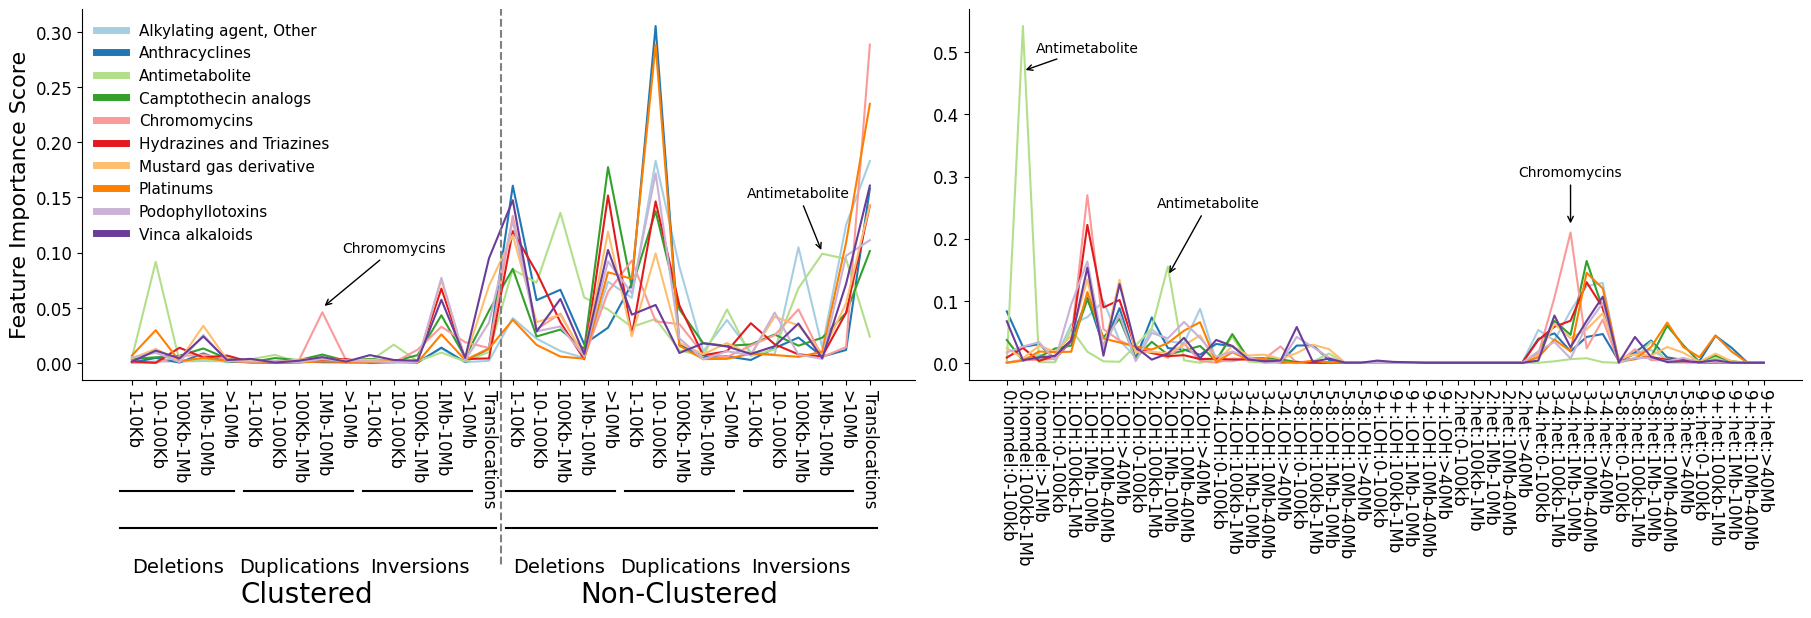

In [59]:
fig = plt.figure(figsize=(18,6), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

f_ax1 = fig.add_subplot(gs[0, 0])
feats_sv.plot(ax=f_ax1, color=line_colors)
ymax = feats_sv.max().max() + 0.02

f_ax1.set_xticks(list(range(0, len(feats_sv))), [x.split('_')[-1] for x in feats_sv.index], rotation=-90, ha="center", fontsize=12)
plt.setp(f_ax1.yaxis.get_majorticklabels(), fontsize=12)
f_ax1.axvline(x = (len(feats_sv)/2) - 0.5, color = 'gray', linestyle = 'dashed')
#f_ax1.text((len(feats_sv)/6), ymax, 'Clustered', dict(size=20))
#f_ax1.text((len(feats_sv)/1.5), ymax, 'Non-Clustered', dict(size=20))

f_ax1.text(0, -0.19, 'Deletions', dict(size=14))
f_ax1.text(4.5, -0.19, 'Duplications', dict(size=14))
f_ax1.text(10, -0.19, 'Inversions', dict(size=14))
f_ax1.text(16, -0.19, 'Deletions', dict(size=14))
f_ax1.text(20.5, -0.19, 'Duplications', dict(size=14))
f_ax1.text(26, -0.19, 'Inversions', dict(size=14))

f_ax1.spines[['top', 'right']].set_visible(False)
f_ax1.get_legend().remove()
f_ax1.annotate('Chromomycins', xy=(8, 0.05),xytext=(11, 0.1), horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
f_ax1.annotate('Antimetabolite', xy=(29, 0.1),xytext=(28, 0.15), horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))

trans = f_ax1.get_xaxis_transform()
y_line = -0.3
f_ax1.plot([-0.5,4.3],[y_line,y_line], color="k", transform=trans, clip_on=False)
f_ax1.plot([4.7,9.3],[y_line,y_line], color="k", transform=trans, clip_on=False)
f_ax1.plot([9.7,14.3],[y_line,y_line], color="k", transform=trans, clip_on=False)
f_ax1.plot([15.7,20.3],[y_line,y_line], color="k", transform=trans, clip_on=False)
f_ax1.plot([20.7,25.3],[y_line,y_line], color="k", transform=trans, clip_on=False)
f_ax1.plot([25.7,30.3],[y_line,y_line], color="k", transform=trans, clip_on=False)

f_ax1.plot([15.5,15.5],[0,-0.5], color = 'gray', linestyle = 'dashed', transform=trans, clip_on=False)

f_ax1.plot([-0.5,15.3],[y_line-0.1,y_line-0.1], color="k", transform=trans, clip_on=False)
f_ax1.plot([15.7,31.3],[y_line-0.1,y_line-0.1], color="k", transform=trans, clip_on=False)

f_ax1.text((len(feats_sv)/7), y_line-0.3, 'Clustered', dict(size=20), transform=trans, clip_on=False)
f_ax1.text((len(feats_sv)/1.7), y_line-0.3, 'Non-Clustered', dict(size=20), transform=trans, clip_on=False)

custom_lines = []
for i in range(feats_sv.shape[1]):
    custom_lines.append(Line2D([], [], color=line_colors[i], marker='_', markersize=10, linestyle='-', lw=5))
f_ax1.legend(custom_lines, feats_sv.columns.tolist(), loc='upper left', fontsize=11, frameon=False)

f_ax1.set_ylabel('Feature Importance Score', fontsize=16)

f_ax2 = fig.add_subplot(gs[0, 1])
feats_cnv.plot(ax=f_ax2, color=line_colors)
f_ax2.set_xticks(list(range(0, len(feats_cnv))), feats_cnv.index, rotation=-90, ha="center", fontsize=12)
plt.setp(f_ax2.yaxis.get_majorticklabels(), fontsize=12)
f_ax2.spines[['top', 'right']].set_visible(False)
f_ax2.get_legend().remove()

f_ax2.annotate('Antimetabolite', xy=(1, 0.47),xytext=(5, 0.5), horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
f_ax2.annotate('Antimetabolite', xy=(10, 0.14),xytext=(12.5, 0.25), horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))
f_ax2.annotate('Chromomycins', xy=(35, 0.22),xytext=(35, 0.3), horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=1))

plt.savefig(os.path.join(fig_out, 'ExFig_9a_rev3.pdf'), bbox_inches="tight", dpi=300)

-----
## Panel b

In [60]:
# Compute pairwise cosine distances and convert to cosine similarity
cosine_sv = 1 - squareform(pdist(feats_sv.T, metric='cosine'))
cosine_sv = pd.DataFrame(cosine_sv, index=feats_sv.columns, columns=feats_sv.columns)

cosine_cnv = 1 - squareform(pdist(feats_cnv.T, metric='cosine'))
cosine_cnv = pd.DataFrame(cosine_cnv, index=feats_cnv.columns, columns=feats_cnv.columns)

cosine_sv.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Mustard gas derivative,Platinums,Podophyllotoxins,Vinca alkaloids
"Alkylating agent, Other",1.000000,0.783571,0.512817,0.797505,0.727756,0.802918,0.781093,0.902378,0.827342,0.718560
Anthracyclines,0.783571,1.000000,0.476637,0.766810,0.667488,0.820220,0.767114,0.878656,0.871484,0.690907
Antimetabolite,0.512817,0.476637,1.000000,0.542400,0.423510,0.537841,0.584587,0.396177,0.565847,0.600542
Camptothecin analogs,0.797505,0.766810,0.542400,1.000000,0.698970,0.934052,0.915996,0.800638,0.907505,0.840500
Chromomycins,0.727756,0.667488,0.423510,0.698970,1.000000,0.760974,0.810705,0.693272,0.709793,0.851642


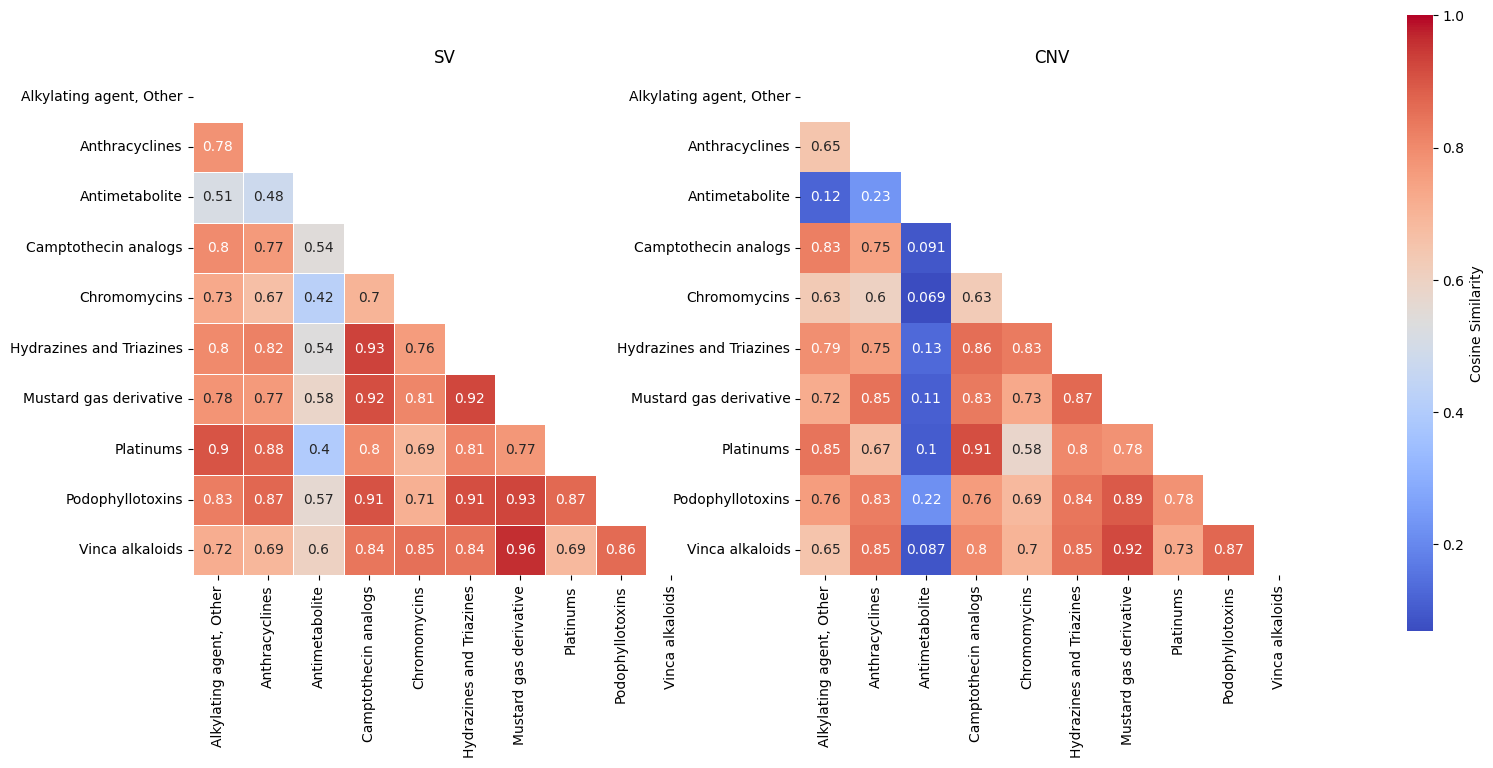

In [61]:
# Create masks for the upper triangles
mask1 = np.triu(np.ones_like(cosine_sv, dtype=bool))
mask2 = np.triu(np.ones_like(cosine_cnv, dtype=bool))

# Create a figure with a specific GridSpec layout
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.3)

# Define a shared colormap and color limits
vmin = min(cosine_sv.min().min(), cosine_cnv.min().min())
vmax = max(cosine_sv.max().max(), cosine_cnv.max().max())

# Plot the first heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cosine_sv, mask=mask1, cmap='coolwarm', cbar=False, ax=ax1, vmin=vmin, vmax=vmax, square=True, annot=True, linewidths=0.5)
ax1.set_title('SV')

# Plot the second heatmap
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(cosine_cnv, mask=mask2, cmap='coolwarm', cbar=False, ax=ax2, vmin=vmin, vmax=vmax, square=True, annot=True, linewidths=0.5)
ax2.set_title('CNV')

# Add a color bar using a new axis for the color bar
cbar_ax = fig.add_subplot(gs[0, 2])
sns.heatmap(cosine_cnv, mask=mask2, cmap='coolwarm', cbar=True, ax=ax2, cbar_ax=cbar_ax, vmin=vmin, vmax=vmax, square=True)
cbar_ax.set_ylabel('Cosine Similarity')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(os.path.join(fig_out, 'ExFig_9b_rev3.pdf'), bbox_inches="tight", dpi=300)